<a href="https://colab.research.google.com/github/Papa-Panda/paper_reading/blob/main/chapter_linear-networks/linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
# !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install d2l==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-inl

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

为了说明矢量化为什么如此重要，我们考虑(**对向量相加的两种方法**)。
我们实例化两个全为1的10000维向量。
在一种方法中，我们将使用Python的for循环遍历向量；
在另一种方法中，我们将依赖对`+`的调用。


In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

由于在本书中我们将频繁地进行运行时间的基准测试，所以[**我们定义一个计时器**]：


In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

现在我们可以对工作负载进行基准测试。

首先，[**我们使用for循环，每次执行一位的加法**]。


In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.20867 sec'

(**或者，我们使用重载的`+`运算符来计算按元素的和**)。


In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00021 sec'

结果很明显，第二种方法比第一种方法快得多。
矢量化代码通常会带来数量级的加速。
另外，我们将更多的数学运算放到库中，而无须自己编写那么多的计算，从而减少了出错的可能性。

## 正态分布与平方损失
:label:`subsec_normal_distribution_and_squared_loss`

接下来，我们通过对噪声分布的假设来解读平方损失目标函数。

正态分布和线性回归之间的关系很密切。
正态分布（normal distribution），也称为*高斯分布*（Gaussian distribution），
最早由德国数学家高斯（Gauss）应用于天文学研究。
简单的说，若随机变量$x$具有均值$\mu$和方差$\sigma^2$（标准差$\sigma$），其正态分布概率密度函数如下：

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

下面[**我们定义一个Python函数来计算正态分布**]。


In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

我们现在(**可视化正态分布**)。


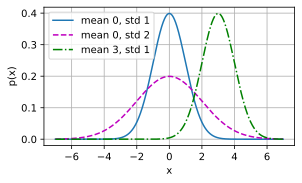

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

就像我们所看到的，改变均值会产生沿$x$轴的偏移，增加方差将会分散分布、降低其峰值。

均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是：
我们假设了观测中包含噪声，其中噪声服从正态分布。
噪声正态分布如下式:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon,$$

其中，$\epsilon \sim \mathcal{N}(0, \sigma^2)$。

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的*似然*（likelihood）：

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的*似然*最大的值：

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

根据极大似然估计法选择的估计量称为*极大似然估计量*。
虽然使许多指数函数的乘积最大化看起来很困难，
但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。
由于历史原因，优化通常是说最小化而不是最大化。
我们可以改为*最小化负对数似然*$-\log P(\mathbf y \mid \mathbf X)$。
由此可以得到的数学公式是：

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

现在我们只需要假设$\sigma$是某个固定常数就可以忽略第一项，
因为第一项不依赖于$\mathbf{w}$和$b$。
现在第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和前面介绍的均方误差是一样的。
幸运的是，上面式子的解并不依赖于$\sigma$。
因此，在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。

## 从线性回归到深度网络

到目前为止，我们只谈论了线性模型。
尽管神经网络涵盖了更多更为丰富的模型，我们依然可以用描述神经网络的方式来描述线性模型，
从而把线性模型看作一个神经网络。
首先，我们用“层”符号来重写这个模型。

### 神经网络图

深度学习从业者喜欢绘制图表来可视化模型中正在发生的事情。
在 :numref:`fig_single_neuron`中，我们将线性回归模型描述为一个神经网络。
需要注意的是，该图只显示连接模式，即只显示每个输入如何连接到输出，隐去了权重和偏置的值。

![线性回归是一个单层神经网络。](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

在 :numref:`fig_single_neuron`所示的神经网络中，输入为$x_1, \ldots, x_d$，
因此输入层中的*输入数*（或称为*特征维度*，feature dimensionality）为$d$。
网络的输出为$o_1$，因此输出层中的*输出数*是1。
需要注意的是，输入值都是已经给定的，并且只有一个*计算*神经元。
由于模型重点在发生计算的地方，所以通常我们在计算层数时不考虑输入层。
也就是说， :numref:`fig_single_neuron`中神经网络的*层数*为1。
我们可以将线性回归模型视为仅由单个人工神经元组成的神经网络，或称为单层神经网络。

对于线性回归，每个输入都与每个输出（在本例中只有一个输出）相连，
我们将这种变换（ :numref:`fig_single_neuron`中的输出层）
称为*全连接层*（fully-connected layer）或称为*稠密层*（dense layer）。
下一章将详细讨论由这些层组成的网络。

### 生物学

线性回归发明的时间（1795年）早于计算神经科学，所以将线性回归描述为神经网络似乎不合适。
当控制学家、神经生物学家沃伦·麦库洛奇和沃尔特·皮茨开始开发人工神经元模型时，
他们为什么将线性模型作为一个起点呢？
我们来看一张图片 :numref:`fig_Neuron`：
这是一张由*树突*（dendrites，输入终端）、
*细胞核*（nucleus，CPU）组成的生物神经元图片。
*轴突*（axon，输出线）和*轴突端子*（axon terminal，输出端子）
通过*突触*（synapse）与其他神经元连接。

![真实的神经元。](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

树突中接收到来自其他神经元（或视网膜等环境传感器）的信息$x_i$。
该信息通过*突触权重*$w_i$来加权，以确定输入的影响（即，通过$x_i w_i$相乘来激活或抑制）。
来自多个源的加权输入以加权和$y = \sum_i x_i w_i + b$的形式汇聚在细胞核中，
然后将这些信息发送到轴突$y$中进一步处理，通常会通过$\sigma(y)$进行一些非线性处理。
之后，它要么到达目的地（例如肌肉），要么通过树突进入另一个神经元。

当然，许多这样的单元可以通过正确连接和正确的学习算法拼凑在一起，
从而产生的行为会比单独一个神经元所产生的行为更有趣、更复杂，
这种想法归功于我们对真实生物神经系统的研究。

当今大多数深度学习的研究几乎没有直接从神经科学中获得灵感。
我们援引斯图尔特·罗素和彼得·诺维格在他们的经典人工智能教科书
*Artificial Intelligence:A Modern Approach* :cite:`Russell.Norvig.2016`
中所说的：虽然飞机可能受到鸟类的启发，但几个世纪以来，鸟类学并不是航空创新的主要驱动力。
同样地，如今在深度学习中的灵感同样或更多地来自数学、统计学和计算机科学。

## 小结

* 机器学习模型中的关键要素是训练数据、损失函数、优化算法，还有模型本身。
* 矢量化使数学表达上更简洁，同时运行的更快。
* 最小化目标函数和执行极大似然估计等价。
* 线性回归模型也是一个简单的神经网络。

## 练习

1. 假设我们有一些数据$x_1, \ldots, x_n \in \mathbb{R}$。我们的目标是找到一个常数$b$，使得最小化$\sum_i (x_i - b)^2$。
    1. 找到最优值$b$的解析解。
    1. 这个问题及其解与正态分布有什么关系?
1. 推导出使用平方误差的线性回归优化问题的解析解。为了简化问题，可以忽略偏置$b$（我们可以通过向$\mathbf X$添加所有值为1的一列来做到这一点）。
    1. 用矩阵和向量表示法写出优化问题（将所有数据视为单个矩阵，将所有目标值视为单个向量）。
    1. 计算损失对$w$的梯度。
    1. 通过将梯度设为0、求解矩阵方程来找到解析解。
    1. 什么时候可能比使用随机梯度下降更好？这种方法何时会失效？
1. 假定控制附加噪声$\epsilon$的噪声模型是指数分布。也就是说，$p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$
    1. 写出模型$-\log P(\mathbf y \mid \mathbf X)$下数据的负对数似然。
    1. 请试着写出解析解。
    1. 提出一种随机梯度下降算法来解决这个问题。哪里可能出错？（提示：当我们不断更新参数时，在驻点附近会发生什么情况）请尝试解决这个问题。


[Discussions](https://discuss.d2l.ai/t/1775)
